### ADA-II – HW4 - Team 1 - 04/44/2022
Jen Arriaza (Lead) - 65%<br>
Junyu (Eric) Lin - 35%<br>
Byron Liu - 0%<br>
**Algorithms**: Random Forest <br>
**Course**: Applied Data Analytics II, 2022 Spring<br>
**Professor**: Stavros Zervoudakis

#### Problem Statement:
Using Random Forest Classification, we will investigate the red wine quality dataset for feature importance. This will be useful for feature selection in and building better predictive models. The algorithm will earch for the most important features among random subsets of features, and will then evaluate the model performance.

In [31]:
# Importing necessary libraries/packages
import os
import pandas as pd
import seaborn as sns
import numpy as np
import collections


# Ignore printing warnings for general readability
import warnings 
warnings.filterwarnings("ignore")


from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

from collections import Counter
from sklearn.preprocessing import LabelEncoder


from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import opendatasets as od
od.download("https://www.kaggle.com/yasserh/wine-quality-dataset")

Skipping, found downloaded files in "./wine-quality-dataset" (use force=True to force download)


In [5]:
df = pd.read_csv('WineQT.csv')

In [6]:
df.head(3)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,2


In [7]:
# Check datatypes & missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1143 non-null   float64
 1   volatile acidity      1143 non-null   float64
 2   citric acid           1143 non-null   float64
 3   residual sugar        1143 non-null   float64
 4   chlorides             1143 non-null   float64
 5   free sulfur dioxide   1143 non-null   float64
 6   total sulfur dioxide  1143 non-null   float64
 7   density               1143 non-null   float64
 8   pH                    1143 non-null   float64
 9   sulphates             1143 non-null   float64
 10  alcohol               1143 non-null   float64
 11  quality               1143 non-null   int64  
 12  Id                    1143 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 116.2 KB


In [8]:
# Renaming columns for readability
df.rename(columns = {'fixed acidity': 'fixed_acidity', 'volatile acidity': 'volatile_acidity', 'citric acid': 'citric_acid', 'residual sugar': 'residual_sugar'}, inplace=True)

## Visualizing response

5    483
6    462
7    143
4     33
8     16
3      6
Name: quality, dtype: int64

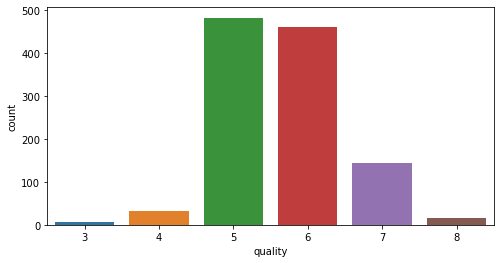

In [9]:
plt.figure(figsize=(8, 4))
sns.countplot(df["quality"])
df["quality"].value_counts()

### Transformation
The response 'quality' score can be better interpreted as low, mid, high quality--therefore we will transform the scores into categories.

- low: less than 5
- mid: 5 - 6
- high: 7 - 10

In [10]:
quality = df["quality"].values
category = []
for num in quality:
    if num < 5:
        category.append("Low")
    elif num > 6:
        category.append("High")
    else:
        category.append("Mid")

In [11]:
# Get counts for each new response category

[(i, category.count(i)) for i in set(category)]

[('Low', 39), ('High', 159), ('Mid', 945)]

### Plot new Quality response category

<AxesSubplot:ylabel='count'>

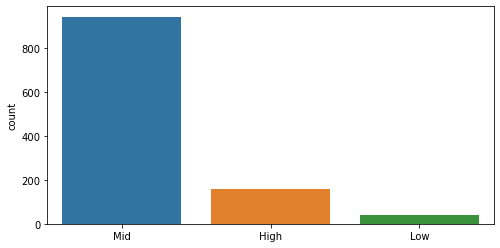

In [12]:
plt.figure(figsize=(8, 4))
sns.countplot(category)

### Handling outliers in dataset (Z-score based)

In [14]:
from scipy import stats
z = np.abs(stats.zscore(df))
print(z)

[[0.52157961 0.93933222 1.36502663 ... 0.96338181 0.81572437 1.73561799]
 [0.29259344 1.94181282 1.36502663 ... 0.59360107 0.81572437 1.73346186]
 [0.29259344 1.27349242 1.16156762 ... 0.59360107 0.81572437 1.73130573]
 ...
 [1.20853813 0.38239855 0.9581086  ... 0.05351522 0.81572437 1.70125196]
 [1.38027776 0.10393172 0.8563791  ... 0.70063152 0.42578423 1.70340809]
 [1.38027776 0.6330187  0.75464959 ... 0.22382033 0.81572437 1.70772035]]


In [15]:
threshold = 3
print(np.where(z > 3))

(array([  11,   13,   30,   31,   32,   59,   61,   64,   75,   75,   87,
         88,   96,   98,  103,  103,  103,  103,  114,  115,  129,  142,
        161,  161,  167,  170,  171,  182,  182,  200,  230,  231,  240,
        244,  249,  272,  275,  275,  278,  278,  287,  289,  311,  311,
        324,  329,  339,  339,  348,  366,  368,  388,  397,  397,  399,
        399,  407,  419,  421,  424,  430,  452,  453,  454,  460,  460,
        462,  462,  462,  485,  490,  490,  493,  514,  520,  538,  557,
        572,  589,  597,  598,  627,  627,  644,  648,  654,  655,  690,
        714,  738,  738,  756,  760,  760,  761,  761,  787,  831,  871,
        890,  898,  898,  914,  915,  919,  922,  922,  931,  933,  934,
        934,  935,  965,  971,  973,  973,  975,  975, 1022, 1022, 1022,
       1046, 1051, 1051, 1053, 1053, 1055, 1066, 1074, 1111, 1111, 1111,
       1122]), array([ 9,  4,  4,  9,  8,  9,  9,  9,  4,  9,  1,  1, 10, 10,  2,  4,  8,
        9,  3,  3,  4,  1,  4,  9

In [16]:
df_o = df[(z < 3).all(axis=1)]

Results before & after outlier removal

In [17]:
df.shape

(1143, 13)

In [18]:
df_o.shape

(1041, 13)

## Setup model train/test

In [19]:
from sklearn.model_selection import train_test_split
X = df_o.drop(columns = 'quality')
y = df_o['quality']

### Fit basic random forest model

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train,y_train)

RandomForestClassifier()

In [21]:
y_pred = clf.predict(X_test)

In [22]:
# Print model accuracy

from sklearn import metrics
print('Accuracy: ', metrics.accuracy_score(y_test,y_pred))

Accuracy:  0.7033492822966507


Calculaing levels of feature importance

In [24]:
feature_imp = pd.Series(clf.feature_importances_, index=df_o.columns[:12]).sort_values(ascending=False)
feature_imp

alcohol                 0.140681
sulphates               0.111372
total sulfur dioxide    0.093908
volatile_acidity        0.093852
quality                 0.079326
density                 0.078087
pH                      0.075693
chlorides               0.074546
citric_acid             0.068855
fixed_acidity           0.064273
residual_sugar          0.061691
free sulfur dioxide     0.057717
dtype: float64

Visualize feature importance from Random Forest classifier

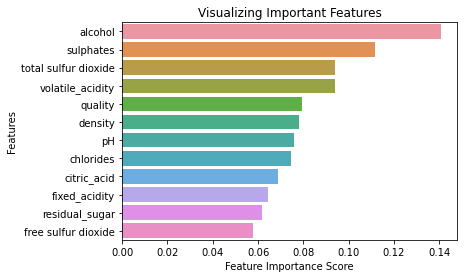

In [27]:
sns.barplot(x=feature_imp, y=feature_imp.index)

plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

### Tuning parameters with RandomSearch Cross-Validation

In [28]:
#Random Search Cross Validation

from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state = 42)
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [29]:

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(2, 14, num = 7)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [2, 4, 6, 8, 10, 12, 14, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


Search for best parameters to use in model

In [32]:
# Use the random grid to search for best hyperparameters

#create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train,y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   40.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.8min finished


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [2, 4, 6, 8, 10, 12, 14,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [33]:
rf_random.best_params_

{'n_estimators': 1800,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 12,
 'bootstrap': True}

### Evaluate model performance

In [34]:
def evaluate(model, X_test, y_test):
    predictions = model.predict(X_test)
    errors = abs(predictions - y_test)
    mape = 100 * np.mean(errors / y_test)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy
base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_test,y_test)

Model Performance
Average Error: 0.4488 degrees.
Accuracy = 91.88%.


In [35]:
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test)

Model Performance
Average Error: 0.4276 degrees.
Accuracy = 92.32%.


In [36]:
print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Improvement of 0.48%.


In [37]:
#Grid Search with Cross Validation
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [8, 10, 12, 14],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [38]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   43.9s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed:  4.0min finished


{'bootstrap': True,
 'max_depth': 10,
 'max_features': 3,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 200}

In [39]:
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, X_test, y_test)

Model Performance
Average Error: 0.4477 degrees.
Accuracy = 91.98%.


#### Conclusion
Tuning with RandomSearch cross-validation resuled in higher accuracy on test